# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test set features


In [2]:
!tar xzf /content/drive/MyDrive/stat453/test2015.tar.gz

In [25]:
!ls data/vqa/feats/test2015/ | wc -l

81434


In [ ]:
!git clone https://github.com/zhaoyi3264/openvqa.git

In [5]:
!mv test2015/ openvqa/data/vqa/feats/
!mkdir openvqa/data/vqa/feats/train2014
!mkdir openvqa/data/vqa/feats/val2014

## Raw data

In [14]:
!cp /content/drive/MyDrive/stat453/raw/*.json openvqa/data/vqa/raw/

## Pre-trained model (BAN-8)

In [ ]:
# !wget https://awma1-my.sharepoint.com/:u:/g/personal/yuz_l0_tn/EbJgyL7FPTFAqzMm3HB1xDIBjXpWygOoXrdnDZKEIu34rg?download=1 -O epoch13.pkl

In [21]:
!mkdir -p openvqa/ckpts/ckpt_ban_8/
!cp /content/drive/MyDrive/stat453/ckpts/ckpt_ban_8/epoch13.pkl openvqa/ckpts/ckpt_ban_8/

## Spacy model

In [ ]:
# !wget https://github.com/explosion/spacy-models/releases/download/en_vectors_web_lg-2.1.0/en_vectors_web_lg-2.1.0.tar.gz -O en_vectors_web_lg-2.1.0.tar.gz
!pip install -q /content/drive/MyDrive/stat453/en_vectors_web_lg-2.1.0.tar.gz

In [ ]:
# %load_ext autoreload
# %autoreload 2

## Source code

https://github.com/MILVLG/openvqa/blob/6b9bfeb2e6462b946d7e7866ffc49dd7a8bcece3/openvqa/core/base_cfgs.py
https://github.com/MILVLG/openvqa/blob/6b9bfeb2e6462b946d7e7866ffc49dd7a8bcece3/utils/exec.py#L36
https://github.com/MILVLG/openvqa/blob/6b9bfeb2e6462b946d7e7866ffc49dd7a8bcece3/utils/test_engine.py#L49
https://github.com/MILVLG/openvqa/blob/6b9bfeb2e6462b946d7e7866ffc49dd7a8bcece3/openvqa/datasets/vqa/vqa_loader.py#L68

# Load dataset

In [15]:
%cd /content/openvqa/

/content/openvqa


In [1]:
import gc
import json

import numpy as np
import torch
import torch.utils.data as Data
import yaml
from yaml import CLoader

from openvqa.datasets.dataset_loader import DatasetLoader, EvalLoader
from openvqa.datasets.vqa.eval.vqa import VQA
from openvqa.datasets.vqa.eval.vqaEval import VQAEval
from openvqa.models.model_loader import CfgLoader, ModelLoader
from run import create_parser
from utils.test_engine import test_engine

parser = create_parser()
arg = '--RUN val --MODEL butd --DATASET vqa --NW 2 --CKPT_V butd --CKPT_E 13'
args = parser.parse_args(arg.split(' '))

cfg_file = "configs/{}/{}.yml".format(args.DATASET, args.MODEL)
with open(cfg_file, 'r') as f:
    yaml_dict = yaml.load(f, Loader=CLoader)

__C = CfgLoader(yaml_dict['MODEL_USE']).load()
args = __C.str_to_bool(args)
args_dict = __C.parse_to_dict(args)

args_dict = {**yaml_dict, **args_dict}
__C.add_args(args_dict)
__C.proc()

print('Hyper Parameters:')
print(__C)

Checking dataset ........
Finished!

Hyper Parameters:
{ BATCH_SIZE        }->512
{ BBOX_NORMALIZE    }->False
{ CACHE_PATH        }->./results/cache
{ CKPTS_PATH        }->./ckpts
{ CKPT_EPOCH        }->13
{ CKPT_PATH         }->None
{ CKPT_VERSION      }->butd
{ CLASSIFER_DROPOUT_R }->0.5
{ DATASET           }->vqa
{ DATA_PATH         }->{'vqa': './data/vqa', 'gqa': './data/gqa', 'clevr': './data/clevr'}
{ DATA_ROOT         }->./data
{ DEVICES           }->[0]
{ DROPOUT_R         }->0.2
{ EVAL_BATCH_SIZE   }->256
{ EVAL_EVERY_EPOCH  }->False
{ FEATS_PATH        }->{'vqa': {'train': './data/vqa/feats/train2014', 'val': './data/vqa/feats/val2014', 'test': './data/vqa/feats/test2015'}, 'gqa': {'default-frcn': './data/gqa/feats/gqa-frcn', 'default-grid': './data/gqa/feats/gqa-grid'}, 'clevr': {'train': './data/clevr/feats/train', 'val': './data/clevr/feats/val', 'test': './data/clevr/feats/test'}}
{ FEAT_SIZE         }->{'vqa': {'FRCN_FEAT_SIZE': (100, 2048), 'BBOX_FEAT_SIZE': (100, 5)},

In [3]:
dataset = DatasetLoader(__C).DataSet()

data_size = dataset.data_size
token_size = dataset.token_size
ans_size = dataset.ans_size
pretrained_emb = dataset.pretrained_emb

 ========== Dataset size: 214354
 ========== Question token vocab size: 20573
 ========== Answer token vocab size (occur more than 8 times): 3129
Finished!



In [4]:
net = ModelLoader(__C).Net(
    __C,
    pretrained_emb,
    token_size,
    ans_size
)

# net.cuda()
net.eval()

with open('ckpts/ckpt_butd/epoch13.pkl', 'rb') as f:
    state = torch.load(f, map_location='cpu')
net.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [5]:
dataloader = Data.DataLoader(
    dataset,
    batch_size=__C.EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=__C.NUM_WORKERS,
    pin_memory=__C.PIN_MEM
)

[https://github.com/MILVLG/openvqa/blob/master/openvqa/models/butd/tda.py](https://github.com/MILVLG/openvqa/blob/master/openvqa/models/butd/tda.py)

In [40]:
%%time
for frcn_feat, grid_feat, bbox_feat, ques_ix, ans_iter in dataloader:
    lang_feat = net.embedding(ques_ix)
    lang_feat, _ = net.rnn(lang_feat)
#     print('frcn_feat.shape:\t', frcn_feat.shape)
#     print('lang_feat.shape:\t', lang_feat.shape)

    img_feat, _ = net.adapter(frcn_feat, grid_feat, bbox_feat)

    q, v = lang_feat[:, -1], img_feat
#     print('v.shape:\t\t', v.shape)
#     print('q.shape:\t\t', q.shape)
    
    att = net.backbone.v_att(q, v)
#     print('att.shape:\t\t', att.shape)
    
#     atted_v = (att * v).sum(1)
#     print('atted_v.shape:\t\t', atted_v.shape)
    
#     q_repr = net.backbone.q_net(q)
#     v_repr = net.backbone.v_net(atted_v)
#     print('v_repr.shape:\t\t', v_repr.shape)
#     print('q_repr.shape:\t\t', q_repr.shape)
    break

CPU times: user 9.13 s, sys: 1.48 s, total: 10.6 s
Wall time: 7.2 s


In [ ]:
from collections import Counter
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams['font.size'] = 12

with open('results/cache/result_run_9268772.json', 'r') as f:
    pred = json.load(f)
with open('data/vqa/raw/v2_OpenEnded_mscoco_val2014_questions.json') as f:
    ques = json.load(f)['questions']
with open('data/vqa/raw/v2_mscoco_val2014_annotations.json') as f:
    anno = json.load(f)['annotations']
pred_df = pd.DataFrame(pred)
ques_df = pd.DataFrame(ques)
anno_df = pd.DataFrame(anno)

df = pred_df.merge(ques_df, how='inner').merge(anno_df, how='inner')
df = df.reindex(columns=['image_id','question_id', 'question_type', 'question',
                         'answer_type', 'multiple_choice_answer', 'answers', 'answer'],
                copy=False)
# df.rename(columns=lambda col: 'prediction' if col == 'answer' else col, inplace=True)

del pred, ques, anno, pred_df, ques_df, anno_df

In [45]:
df.head()

,image_id,question_id,question_type,question,answer_type,multiple_choice_answer,answers,answer
0,262148,262148000,none of the above,Where is he looking?,other,down,"[{'answer': 'down', 'answer_confidence': 'yes'...",down
1,262148,262148001,what are the,What are the people in the background doing?,other,watching,"[{'answer': 'spectating', 'answer_confidence':...",watching
2,262148,262148002,what is,What is he on top of?,other,picnic table,"[{'answer': 'table', 'answer_confidence': 'yes...",picnic table
3,393225,393225000,what,What website copyrighted the picture?,other,foodiebakercom,"[{'answer': 'foodiebakercom', 'answer_confiden...",flickr
4,393225,393225001,is this a,Is this a creamy soup?,yes/no,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no


In [67]:
att_weights = att[0][:image_info['num_bbox']].detach().numpy()
att_weights = att_weights.ravel()
att_weights

array([2.5354853e-02, 7.5977556e-03, 1.4288769e-03, 6.6726711e-03,
       1.2955396e-01, 5.7072964e-02, 3.8343132e-02, 1.3999376e-01,
       9.3397997e-02, 1.4021274e-03, 1.9949338e-01, 1.2927374e-01,
       1.4821576e-02, 1.4661065e-03, 1.2017309e-03, 3.0533285e-03,
       2.2036819e-04, 6.1998427e-02, 3.0697882e-04, 5.9254897e-05,
       1.1731223e-03, 3.8389080e-05, 2.0489120e-04, 4.2815559e-04,
       4.5176954e-03, 2.3042402e-04, 4.5931051e-03, 2.3120690e-04,
       7.1089168e-04, 2.5921927e-03, 1.8672001e-05, 8.4692910e-03,
       1.2288127e-03, 4.2879628e-03, 9.0136443e-04, 2.7383907e-02,
       4.4104797e-04, 2.1751106e-03, 1.8215738e-02, 1.2420953e-03,
       8.2000848e-03], dtype=float32)

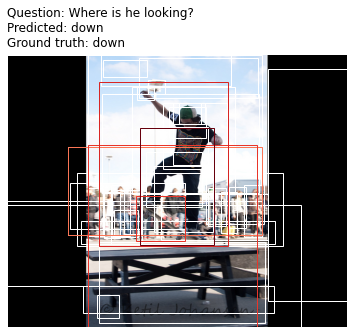

In [70]:
row = df.loc[0]
k = 5

image_id = row['image_id']
question = row['question']
pred = row['answer']
gt = row['answers'][0]['answer']

with np.load(f'data/vqa/feats/val2014/COCO_val2014_000000{image_id:06}.jpg.npz') as npz:
    image_info = dict(zip(npz.files, npz.values()))

image = plt.imread(f'data/vqa/raw/val2014/COCO_val2014_000000{image_id:06}.jpg')

fig, ax = plt.subplots(figsize=(12,5))
ax.imshow(image)

idx = att_weights.argsort()
att_weights_k = att_weights[idx][-k:]
norm = mpl.colors.Normalize()
cmap = plt.cm.Reds
norm(att_weights)
colors = cmap(norm(att_weights_k))

for bbox in image_info['bbox']:
    x0, y0, x1, y1 = bbox
    bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='white')
    ax.add_patch(bbox_patch)

bboxes = image_info['bbox'][idx][-k:]
for bbox, color in zip(bboxes, colors):
    x0, y0, x1, y1 = bbox
    bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color)
    ax.add_patch(bbox_patch)

text = f'Question: {question}\nPredicted: {pred}\nGround truth: {gt}'
ax.text(0, 1.1, text, transform=ax.transAxes, va='center', ha='left')
ax.set_axis_off()

# Prediction (on test set)

In [8]:
%%time
ans_ix_list = []
pred_list = []

for step, (
        frcn_feat_iter,
        grid_feat_iter,
        bbox_feat_iter,
        ques_ix_iter,
        ans_iter
    ) in enumerate(dataloader):
    print("\rEvaluation: [step %4d/%4d]" % (
        step,
        int(data_size / __C.EVAL_BATCH_SIZE),
    ), end='          ')

#     frcn_feat_iter = frcn_feat_iter.cuda()
#     grid_feat_iter = grid_feat_iter.cuda()
#     bbox_feat_iter = bbox_feat_iter.cuda()
#     ques_ix_iter = ques_ix_iter.cuda()

    pred = net(
        frcn_feat_iter,
        grid_feat_iter,
        bbox_feat_iter,
        ques_ix_iter
    )

    pred_np = pred.cpu().data.numpy()
    pred_argmax = np.argmax(pred_np, axis=1)
    
    if pred_argmax.shape[0] != __C.EVAL_BATCH_SIZE:
        pred_argmax = np.pad(
            pred_argmax,
            (0, __C.EVAL_BATCH_SIZE - pred_argmax.shape[0]),
            mode='constant',
            constant_values=-1
        )

    ans_ix_list.append(pred_argmax)
    
    if __C.TEST_SAVE_PRED:
        if pred_np.shape[0] != __C.EVAL_BATCH_SIZE:
            pred_np = np.pad(
                pred_np,
                ((0, __C.EVAL_BATCH_SIZE - pred_np.shape[0]), (0, 0)),
                mode='constant',
                constant_values=-1
            )

        pred_list.append(pred_np)
    break

# Evaluation: [step 6698/6698]
# CPU times: user 14h 57min 55s, sys: 19min 55s, total: 15h 17min 51s
# Wall time: 7h 40min 34s
# Evaluation: [step 13993/13993]
# CPU times: user 13min 48s, sys: 8min 59s, total: 22min 47s
# Wall time: 35min 22s

Evaluation: [step    0/ 837]          CPU times: user 8.84 s, sys: 1.22 s, total: 10.1 s
Wall time: 6.76 s


In [36]:
ans_ix_list = np.array(ans_ix_list).reshape(-1)

qid_list = [ques['question_id'] for ques in dataset.ques_list]
ans_size = dataset.ans_size

result = [{
        'answer': dataset.ix_to_ans[str(ans_ix_list[qix])],
        'question_id': int(qid_list[qix])
    } for qix in range(qid_list.__len__())]

result_eval_file = __C.CACHE_PATH + '/result_run_' + __C.VERSION
log_file = __C.LOG_PATH + '/log_run_' + __C.VERSION + '.txt'
result_eval_file += '.json'
print('Save the result to file: {}'.format(result_eval_file))
with open(result_eval_file, 'w') as f:
    json.dump(result, f)

Save the result to file: ./results/cache/result_run_6911998.json


# Evaluation (on validation set)

In [ ]:
result_eval_file = __C.CACHE_PATH + '/result_run_' + __C.VERSION
result_eval_file += '.json'

ques_file_path = __C.RAW_PATH[__C.DATASET][__C.SPLIT['val']]
ans_file_path = __C.RAW_PATH[__C.DATASET][__C.SPLIT['val'] + '-anno']
# uncomment line 165-166 in http://localhost:8888/edit/openvqa/openvqa/datasets/vqa/eval/vqa.py
vqa = VQA(ans_file_path, ques_file_path)
vqaRes = vqa.loadRes(result_eval_file, ques_file_path)

loading VQA annotations and questions into memory...
0:00:05.052310
creating index...
index created!
Loading and preparing results...     
DONE (t=0.46s)
creating index...
index created!


In [ ]:
vqaEval = VQAEval(vqa, vqaRes, n=2)

# quesIds = [d['question_id'] for d in result]
# vqaEval.evaluate(quesIds)
vqaEval.evaluate()

computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


In [ ]:
vqaEval.accuracy

{'overall': 84.09,
 'perQuestionType': {'none of the above': 82.19,
  'what are the': 75.57,
  'what is': 75.66,
  'what': 69.0,
  'is this a': 97.88,
  'is this': 97.46,
  'what is the man': 84.12,
  'how many': 75.92,
  'what does the': 48.29,
  'why': 46.35,
  'is it': 98.84,
  'why is the': 47.41,
  'what color is the': 92.15,
  'is there a': 98.67,
  'is the': 96.79,
  'is that a': 97.79,
  'are these': 96.65,
  'are the': 96.26,
  'what is the': 75.58,
  'which': 68.28,
  'could': 98.61,
  'are there': 98.21,
  'what kind of': 76.9,
  'has': 97.16,
  'what color are the': 91.07,
  'are there any': 99.08,
  'is this person': 98.05,
  'does the': 97.25,
  'where is the': 60.6,
  'how many people are': 74.58,
  'can you': 97.58,
  'what type of': 77.29,
  'what is the color of the': 92.4,
  'what is on the': 76.11,
  'does this': 97.48,
  'is this an': 97.49,
  'who is': 63.25,
  'what is this': 84.76,
  'is there': 98.29,
  'are': 95.61,
  'what time': 45.95,
  'how': 54.52,
  'wha